In [1]:
# Modules

import numpy as np
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

from joblib import Parallel, delayed

In [2]:

    
# Class for the model

class cann_model_o:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 10.0
    
    tau1 = 50.0
    tau2 = 500.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.get("k", 0.5);         # rescaled inhibition
        self.a = argument.get("a", 0.5);         # range of excitatory connection
        self.N = argument.get("N", 200);         # number of units / neurons
        self.alpha = argument.get("alpha", 0); # range of excitatory connection
        self.beta = argument.get("beta", 0);   # number of units / neurons
        self.sti_v = argument.get("sti_v", 0);    # number of stimulus velocity
        self.A = argument.get("A", 0);    # size of stimulus 
        self.dx = self.z_range / self.N     # separation between neurons
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.zeros((self.N, self.N));
        for i in range(self.Jxx.shape[0]):
            for j in range(self.Jxx.shape[1]):
                self.Jxx[i][j] = \
                np.exp(-0.5 * np.square(self.dist(self.x[i] \
                                                  - self.x[j]) / self.a)) \
                / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N)*3);    # initialize neuronal inputs
        self.r = np.zeros((self.N));    # initialize neuronal activities
        self.input = np.zeros((self.N));    # initialial the external input
    
    # function for setting external iput for each neuron
    def set_input(self, A, z0):
        self.input = \
        A * np.exp(-0.25 * np.square(self.dist(self.x - z0) / self.a));
    
    # function for calculation of neuronal activity of each neuron
    def cal_r_or_u(self, y):
        u = y[0:self.N]
        u0 = 0.5 * (u + np.abs(u));
        r = np.square(u0);
        B = 1.0 + 0.125 * self.k * np.sum(r) * self.dx \
        / (np.sqrt(2*np.pi) * self.a);
        r = r / B;
        return r;
    
    # calculate the centre of mass of u
    def cm_of_u(self, y):
        u = y[0:self.N]
        max_i = u.argmax()
        cm = np.dot(self.dist(self.x - self.x[max_i]), u) / np.sum(u)
        cm = cm + self.x[max_i]
        return cm;
    
    # function of r driving S
    @staticmethod
    def func_S(r):
        sigma = 2
        loc = 6.0
        return sp.stats.norm.cdf(r, loc=loc, scale=sigma)
    
    # function of r driving Q
    @staticmethod
    def func_Q(r):
        sigma = 0.5
        mode = 1.0
        mu = np.log(mode) + sigma ** 2
        return sp.stats.lognorm.pdf(r, sigma, scale=np.exp(mu))
    
    # function for calculation of derivatives
    def get_dydt(self, t, y):
        u = y[self.N*0:self.N*1]
        S = y[self.N*1:self.N*2]
        Q = y[self.N*2:self.N*3]
        
        u = 0.5 * (u + u[::-1])
        
        r = self.cal_r_or_u(u)
        
        I_tot = np.dot(self.Jxx, r) * self.dx + self.input
        
        dudt = \
        -u + (1+S)*(I_tot);
        
        dSdt = -S / self.tau1 + self.alpha * Q * self.func_S(r)
        
        dQdt = -Q / self.tau2 - self.alpha * Q * self.func_S(r) + self.beta * (1-Q) * self.func_Q(I_tot)
        
        dudt = dudt / self.tau;
        
        return np.concatenate((dudt, dSdt, dQdt))
        
 # Class for the model

class cann_model:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 10.0
    
    tau1 = 50.0
    tau2 = 500.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.get("k", 0.5);         # rescaled inhibition
        self.a = argument.get("a", 0.5);         # range of excitatory connection
        self.N = argument.get("N", 200);         # number of units / neurons
        self.alpha = argument.get("alpha", 5); # range of excitatory connection
        self.beta = argument.get("beta", 5);   # number of units / neurons
        self.A = argument.get("A", 0);    # size of stimulus 
        self.dx = self.z_range / self.N     # separation between neurons
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.zeros((self.N, self.N));
        for i in range(self.Jxx.shape[0]):
            for j in range(self.Jxx.shape[1]):
                self.Jxx[i][j] = \
                np.exp(-0.5 * np.square(self.dist(self.x[i] \
                                                  - self.x[j]) / self.a)) \
                / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N)*3);    # initialize neuronal inputs
        self.r = np.zeros((self.N));    # initialize neuronal activities
        self.input = np.zeros((self.N));    # initialial the external input
    
    # function for setting external iput for each neuron
    def set_input(self, A, z0):
        self.input = \
        A * np.exp(-0.25 * np.square(self.dist(self.x - z0) / self.a));
    
    # function for calculation of neuronal activity of each neuron
    def cal_r_or_u(self, y):
        u = y[0:self.N]
        u0 = 0.5 * (u + np.abs(u));
        r = np.square(u0);
        B = 1.0 + 0.125 * self.k * np.sum(r) * self.dx \
        / (np.sqrt(2*np.pi) * self.a);
        r = r / B;
        return r;
    
    # calculate the centre of mass of u
    def cm_of_u(self, y):
        u = y[0:self.N]
        max_i = u.argmax()
        cm = np.dot(self.dist(self.x - self.x[max_i]), u) / np.sum(u)
        cm = cm + self.x[max_i]
        return self.dist(cm);
    
    # function of r driving S
    @staticmethod
    def func_S(r):
        sigma = 2
        loc = 6.0
        return sp.stats.norm.cdf(r, loc=loc, scale=sigma)
    
    # function of r driving Q
    @staticmethod
    def func_Q(r):
        sigma = 0.5
        mode = 1.0
        mu = np.log(mode) + sigma ** 2
        return sp.stats.lognorm.pdf(r, sigma, scale=np.exp(mu))
    
    # function for calculation of derivatives
    def get_dydt(self, t, y):
        u = y[self.N*0:self.N*1]
        S = y[self.N*1:self.N*2]
        Q = y[self.N*2:self.N*3]
        
        u = 0.5 * (u + u[::-1])
        
        r = self.cal_r_or_u(u)
        
        I_tot = np.dot(self.Jxx, r) * self.dx + self.input
        
        dudt = \
        -u + (1+S)*(I_tot);
        
        dSdt = -S / self.tau1 + self.alpha * Q * self.func_S(r)
        
        dQdt = -Q / self.tau2 - self.alpha * Q * self.func_S(r) + self.beta * (1-Q) * self.func_Q(I_tot)
        
        dudt = dudt / self.tau;
        
        return np.concatenate((dudt, dSdt, dQdt))       

In [3]:

def one_sim(alpha = 1e-20, beta = 1e-20):

    # Define parameters

    arg = {}

    arg["k"] = 0.5
    arg["a"] = 0.5
    arg["N"] = 200
    arg["A"] = 2
    arg["z0"] = 1

    arg["alpha"] = alpha
    arg["beta"] = beta

    # construct a CANN object
    cann = cann_model(arg)

    # setting up an initial condition of neuronal inputs 
    # so that tracking can be reasonabl for small A and k < 1
    if arg["k"] < 1.0:
        cann.set_input(np.sqrt(32.0)/arg["k"], 0)
    else:
        cann.set_input(np.sqrt(32.0), 0)
    cann.y[0:cann.N] = cann.input
#    cann.y[0:cann.N] = np.zeros(cann.N)

    # setting up an external input according to the inputted parameter
    cann.set_input(arg["A"], 0)

    # run the simulation for 100 tau to excite the network state
    out = spint.solve_ivp(cann.get_dydt, (0, 1000), cann.y, method="RK45");

    # update the network state in the CANN object
    cann.y = out.y[:,-1]

    # setting up an external input according to the inputted parameter
    cann.set_input(0, 0)

    # run the simulation for 100 tau to a stationary state
    out = spint.solve_ivp(cann.get_dydt, (0, 5000), cann.y, method="RK45");

    # update the network state in the CANN object
    cann.y = out.y[:,-1]
    
    u = cann.y[cann.N*0:cann.N*1]
    S = cann.y[cann.N*1:cann.N*2]
    Q = cann.y[cann.N*2:cann.N*3]
    
    x = cann.x
    Jxx = cann.Jxx

    dudx = np.gradient(u, cann.x)
    dSdx = np.gradient(S, cann.x)
    dQdx = np.gradient(Q, cann.x)
    
    dSdx = x * S
    dQdx = x * Q


    B = 1 + 0.125 * cann.k * np.trapz(u*u, x) / (np.sqrt(2.*np.pi)*cann.a)

    r = u*u / B

    I_tot = np.array([np.trapz(Jxx[i]*r, x) for i in range(Jxx.shape[1])])

    # cann = None
    
    inner_int = np.array([np.trapz(Jxx[i]*u*dudx, x) for i in range(Jxx.shape[1])])

    Muu = (-1.0 + 2.0 * np.trapz(dudx * (1.0+S) * inner_int, x) / (B * np.trapz(dudx*dudx, x))) / cann.tau

    MuS = (np.trapz(dudx*dSdx*I_tot, x) / (np.trapz(dudx*dudx, x))) / cann.tau

    MuQ = 0.0

    h = 0.0001

    dfSdx_of_r = (cann.func_S(r + h) - cann.func_S(r - h)) / (2.0 * h)

    MSu= 2.0 * cann.alpha * np.trapz(dSdx*Q*dfSdx_of_r*u*dudx, x) / (B * np.trapz(dSdx*dSdx, x))

    MSS = -1.0 / cann.tau1

    MSQ = cann.alpha * np.trapz(dSdx*dQdx*cann.func_S(r), x) / (np.trapz(dSdx*dSdx, x))

    inner_int = np.array([ np.trapz(Jxx[i] * u * dudx, x) for i in range(Jxx.shape[1])])

    dfQdx_of_I = (cann.func_Q(I_tot + h) - cann.func_Q(I_tot - h)) / (2.0 * h)

    MQu = - np.trapz( dQdx * (2.0*cann.alpha*Q*dfSdx_of_r*u*dudx/B 
                           - 2.0*cann.beta*(1.0-Q)*dfQdx_of_I*inner_int/B), x
    ) /  (np.trapz(dQdx*dQdx, x))

    MQS = 0.0

    MQQ = -1.0 / cann.tau2 - np.trapz(
        dQdx * (cann.alpha*dQdx*cann.func_S(r) + cann.beta*dQdx*cann.func_Q(I_tot)), x
    )/  (np.trapz(dQdx*dQdx, x))

    M = [[Muu, MuS, MuQ], [MSu, MSS, MSQ], [MQu, MQS, MQQ]]

    evals, _ = np.linalg.eig(M)
    
    # print(MQu, np.max(np.real(evals)))
    
    return np.max(np.real(evals))

In [4]:
alpha = np.arange(1e-20, 0.201, 0.001)
beta = np.arange(1e-20, 0.201, 0.001)

all_result = []

for beta_i in beta:
    # local_result = []
    # for alpha_i in alpha:
    #     local_result.append(one_sim(alpha_i, beta_i))
    
    local_result = Parallel(n_jobs=16)(delayed(one_sim)(alpha_i, beta_i) for alpha_i in alpha)
        
    all_result.append(local_result)
        
all_result = np.array(all_result)
np.save("all_eigenvalues.np", all_result)

-5.956893758099662e-07 -1.2348330360935356e-05
2.00264629849625e-05 -1.2348330360931886e-05
4.0136838507408144e-05 -1.2348330360931886e-05
5.985521692121142e-05 -1.2348330360931886e-05
7.924487913864029e-05 -1.2348330360931886e-05
9.834878470695217e-05 -1.2348330360935356e-05
0.00011719904930060319 -1.2348330360931886e-05
0.0001358210138495177 -1.2348330360935356e-05
0.00015423538658466593 -1.2348330360931886e-05
0.00017245951420969855 -1.2348330360935356e-05
0.000266103491547218 -1.2348330360931886e-05
0.0004684059278165003 -1.2295172915455232e-05
0.00046665411665911113 -1.2324686928577577e-05
0.0004667890361610669 -1.2326721457539547e-05
0.000464432137348854 -1.2315898115983215e-05
0.00046663145309571835 -1.2289251461405915e-05
0.00046740723583020067 -1.232409950605029e-05
0.00047096798905437874 -1.2312454379964644e-05
0.00047211746039023725 -1.233831045976963e-05
0.00047466106679472353 -1.2332771641837548e-05
0.00047593208919988195 -1.2341002848303972e-05
-9.973328774935889e-07 -1.2

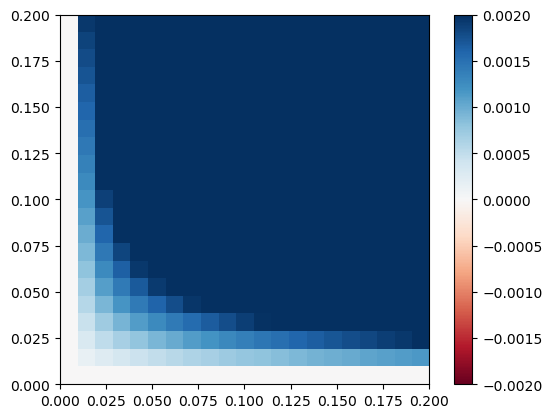

In [5]:
fig = plt.figure()

ax = fig.add_subplot()

extent=(np.min(beta), np.max(beta), np.min(alpha), np.max(alpha))

heatmap = ax.imshow(all_result[::-1], extent=extent, vmax=0.002, vmin=-0.002, cmap='RdBu')

#CR = ax.contour(all_result, (0, 0.0001), extent=extent, colors="black")

manual_loc = [(0,0), (0.1,0.1)]

#ax.clabel(CR, CR.levels, manual=manual_loc)

cb = fig.colorbar(heatmap)

#fig.savefig("eigenvalue.pdf")

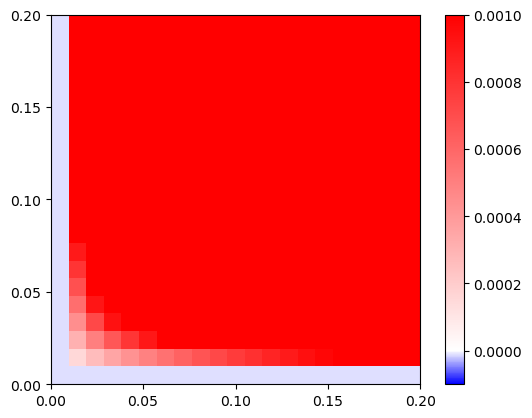

In [6]:
from matplotlib.colors import ListedColormap

red_code = [1,0,0,1]

blue_code = [0,0,1,1]

white_code = [1,1,1,1]

newcolor_code = []

for i in range(40):
    color_tmp = (i/40.) * np.array(white_code) + (1-i/40.) * np.array(blue_code)
    newcolor_code.append(color_tmp.tolist())

for i in range(400):
    color_tmp = (i/400.) * np.array(red_code) + (1-i/400.) * np.array(white_code)
    newcolor_code.append(color_tmp.tolist())

newcolor = ListedColormap(newcolor_code)

fig = plt.figure()

ax = fig.add_subplot()

ax.set_xticks((0,0.05,0.1,0.15,0.2))

ax.set_xlim((0,0.2))

ax.set_yticks((0,0.05,0.1,0.15,0.2))

ax.set_ylim((0,0.2))

extent=(np.min(beta), np.max(beta), np.min(alpha), np.max(alpha))

heatmap = ax.imshow(all_result[::-1], extent=extent, vmax=0.001, vmin=-0.0001, cmap=newcolor)# cmap='RdBu')

#CR = ax.contour(all_result, (0, 0.0001), extent=extent, colors="black", algorithm="threaded")

manual_loc = [(0,0), (0.1,0.1)]

#ax.clabel(CR, CR.levels, manual=manual_loc)

cb = fig.colorbar(heatmap)